In [1]:
import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

from pathos.multiprocessing import ProcessPool
import src.Simulator as sim_system
import src.Optimizer as opt
import src.SimGrad as sim_diff
import scipy as sp
import numpy as np
import torch
import tqdm
import inspect
import h5py


###* Create Simulator object
reactions_file = "../reactions/reactionsCompleteV2.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                    'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                    'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_O_merged.hdf5"
exp_file = os.path.join(output_folder_path, exp_data_file)

sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


####! bounds observables
lower_bounds = np.array([1e-8, 1e-8, 0.0, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, 1e-5, \
                    1.0, 2000
                    ])

upper_bounds = np.array([5e-1, 1e-2, 30.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, \
                    5.0, 5000
                    ])


##! define the default parameters
# params_default_init = np.array([
#                 0.01634, 1.67e-4, 19.75, \
#                 1.0, 1.0, 1e-2, 1e-1, 1e-1, \
#                 1e-2, 1e-1, 1e-1, 1e-1, 1e-1
#                 ])


params_default_paper = np.array([
                0.01634, 1.67e-4, 19.75, \
                1.0, 1.0, 1e-2, 1e-1, 1e-1, 1e-2, 1e-1, 1e-1, 1e-1, 1e-1, \
                1e-2, 1.0, 1.0, 1.0, 1e-1, 1e-1, 1.0, 1.0, 1.0, 1e-1, 1e-1, 1e-2, 1e-1, 1e-1, \
                2.9, 3400
                ])


params_default_init = np.array([
                0.02634, 7.67e-4, 10.75, \
                1.0, 1.0, 1e-2, 1e-1, 1e-1, 1e-2, 1e-1, 1e-1, 1e-1, 1e-1, \
                1e-2, 1.0, 1.0, 1.0, 1e-1, 1e-1, 1.0, 1.0, 1.0, 1e-1, 1e-1, 1e-2, 1e-1, 1e-1, \
                2.9, 3400
                ])


params_default_norm = (params_default_init - lower_bounds) * np.reciprocal(upper_bounds - lower_bounds)

###! optimization function
def func_optimization(params_input, flag='numpy'):
    
    ##! normalize variables
    params = [0] * len(params_input)
    for idx, param in enumerate(params_input):
        params[idx] = lower_bounds[idx] + (upper_bounds[idx] - lower_bounds[idx]) * param
    
    A_d, B_d, E_d = params[0:3]
    SF_30, SF_31, SF_32, SF_33, SF_34, SF_35, SF_36, SF_37, SF_38, SF_39 = params[3:13]
    SF_49, SF_50, SF_51, SF_52, SF_53, SF_54, SF_55, SF_56, SF_57, SF_58, SF_59, SF_60, SF_61, SF_62 = params[13:27]
    Emin, Ealpha = params[27:]
    
    if flag=='numpy':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * np.exp(E_d/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * torch.exp(E_d/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 16, "rate": None, "model_dict": {"Emin": Emin}},
    {"id": 18, "rate": None, "model_dict": {"Emin": Emin}},
    
    {"id": 31, "rate": None, "model_dict": {"SF": SF_31, "nu_d": nu_d_mod}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_30}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_32}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_33}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_34}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_35}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_36}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_37}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_38}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_39}},
    
    {"id": 44, "rate": None, "model_dict": {"Emin": Emin}},
    
    {"id": 49, "rate": None, "model_dict": {"SF": SF_49}},
    {"id": 50, "rate": None, "model_dict": {"SF": SF_50, "Ealpha": Ealpha}},
    {"id": 51, "rate": None, "model_dict": {"SF": SF_51, "Ealpha": Ealpha}},
    {"id": 52, "rate": None, "model_dict": {"SF": SF_52, "Ealpha": Ealpha}},
    {"id": 53, "rate": None, "model_dict": {"SF": SF_53, "Ealpha": Ealpha}},
    {"id": 54, "rate": None, "model_dict": {"SF": SF_54, "Ealpha": Ealpha}},
    {"id": 55, "rate": None, "model_dict": {"SF": SF_55, "Ealpha": Ealpha}},
    {"id": 56, "rate": None, "model_dict": {"SF": SF_56, "Ealpha": Ealpha}},
    {"id": 57, "rate": None, "model_dict": {"SF": SF_57, "Ealpha": Ealpha}},
    {"id": 58, "rate": None, "model_dict": {"SF": SF_58, "Ealpha": Ealpha}},
    {"id": 59, "rate": None, "model_dict": {"SF": SF_59, "Ealpha": Ealpha}},
    {"id": 60, "rate": None, "model_dict": {"SF": SF_60}},
    {"id": 61, "rate": None, "model_dict": {"SF": SF_61}},
    {"id": 62, "rate": None, "model_dict": {"SF": SF_62}}
    ]
    
    return dict_mod_vec


def loss_function(exp, teo, flag='numpy'):
    
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")


optimizer = opt.Optimizer(sim, 
                        lambda params: func_optimization(params, 'numpy'), 
                        lambda exp, teo: loss_function(exp, teo, 'numpy')
                        )


diff = sim_diff.SimDiff(sim, 
                        lambda params: func_optimization(params, 'torch'),
                        params_default=torch.tensor(params_default_norm),
                        gamma_exp_data=sim.gamma_exp_data_arr,
                        loss_function=lambda exp, teo: loss_function(exp, teo, 'torch')
                        )


###* compute the gradients numerically, we assume we dont have an AD module installed

### order 1 for derivatives

def grads_wise_numeric(params, opt_object, hstep = 1e-5):
    params_arr = np.array(params)
    _, residual, _ ,_, _, _ = opt_object.objective_function_diff_full(params_arr)
    
    residuals = []
    for i in range(len(params)):
        step_vec = np.zeros_like(params_arr)
        step_vec[i] = hstep
        _, residual_plus, _ ,_, _, _ = opt_object.objective_function_diff_full(params_arr + step_vec)
        grad = (residual_plus-residual)/hstep
        residuals.append(grad)
        
        print("i grad:: ", i, "-", len(params), "grad: ", np.mean(np.abs(grad)))
    
    return np.array(residuals).T


def create_subspaces_num(params, percent_info, opt_object, eps = 1e-8, reg = 1e-6, tau=1e-4):
    
    grad_errors = grads_wise_numeric(params, opt_object)
    # norms = np.linalg.norm(grad_errors, axis=1, keepdims=True) + eps
    # G = grad_errors / norms  
    G = grad_errors                                   
    F = G.T @ G                                                 
    F_reg = F + reg * np.eye(F.shape[0], dtype=F.dtype)
    
    eigvals, eigvecs = np.linalg.eigh(F_reg)                    

    idx = np.argsort(eigvals)[::-1]
    eigvals_sorted = eigvals[idx]
    eigvecs_sorted = eigvecs[:, idx]
    
    print("eigen_vals_sorted: ", eigvals_sorted)
    
    total_mass = eigvals_sorted.sum()
    cumulative  = np.cumsum(eigvals_sorted)
    ks = int(np.sum(cumulative < percent_info * total_mass)) + 1
    Vs = eigvecs_sorted[:, :ks]
    
    if ks < len(eigvals_sorted):
        ratios = eigvals_sorted[ks:] / eigvals_sorted[ks]
        kl = int(np.count_nonzero(ratios >= tau))
    else:
        kl = 0
    Vl = eigvecs_sorted[:, ks:ks+kl]

    return {
        'phi0': params,
        'dims': len(eigvals_sorted),
        'V_dims': (ks, kl),
        'Vs': Vs,
        'Vl': Vl,
        'eigvals_sorted': eigvals_sorted,
        'eigvecs_sorted': eigvecs_sorted
    }



def Phi_loss(space_string, vars_opt, opt_object, diff_objec, config, string="loss: "):
    
    if not space_string in ['Vs', 'Vl']:
        raise ValueError(f"{space_string} must be Vs or Vl")
    
    params = np.abs(config['phi0'] + config[space_string] @ vars_opt)
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)

    return loss_val




  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_F*O_S*r_40 - 0.02*CO_F*Odb_S*r_61 - 0.02*CO_F*Vdb_S*r_60 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_39 - CO_S*r_37 - CO_S*r_43 - CO_S*r_44 - CO_S*r_45 - CO_S*r_46 + r_32*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0)
  d[COdb_S]/dt = CO_F*Vdb_S*r_60 - COdb_S*O_F*r_62 - COdb_S*r_54 - COdb_S*r_55 - COdb_S*r_56 - COdb_S*r_57 - COdb_S*r_59 + Vdb_S*r_49
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_S*O_F*r_39 - 0.02*COdb_S*O_F*r_62 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_34 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.

In [2]:
### previous  work 
with h5py.File("sloppy_num_1e-3_merged3.h5", "r") as f:
    best_loss = f['best_loss'][:]
    iters = f['iters'][:]
    iters_space = f['type'][:]
    delta_s = f['delta_s'][:]
    delta_phi = f['delta_phi'][:]
    best_params = f['best_params'][:]

In [3]:

percent_info = 0.9
dict_space = create_subspaces_num(best_params, percent_info, optimizer)


i grad::  0 - 29 grad:  1.036961250476537
i grad::  1 - 29 grad:  9.351158165588124
i grad::  2 - 29 grad:  12.780504886102069
i grad::  3 - 29 grad:  0.007991066149054229
i grad::  4 - 29 grad:  0.007992754252857481
i grad::  5 - 29 grad:  248.56305886103533
i grad::  6 - 29 grad:  0.000694962583843231
i grad::  7 - 29 grad:  0.08135221882967411
i grad::  8 - 29 grad:  2.6540709225175553e-05
i grad::  9 - 29 grad:  0.08051339855152688
i grad::  10 - 29 grad:  5.8779535344759495
i grad::  11 - 29 grad:  0.005019503236157618
i grad::  12 - 29 grad:  0.6162395610792641
i grad::  13 - 29 grad:  0.09927790310214575
i grad::  14 - 29 grad:  0.0016042266274043
i grad::  15 - 29 grad:  0.0019024373837592257
i grad::  16 - 29 grad:  0.0016788425912008427
i grad::  17 - 29 grad:  0.0013236716269784028
i grad::  18 - 29 grad:  0.0005281664713976489
i grad::  19 - 29 grad:  0.001484176575450919
i grad::  20 - 29 grad:  0.0010393812710592241
i grad::  21 - 29 grad:  0.002223720051387806
i grad::  

In [14]:

best_params_unnorm = lower_bounds + (upper_bounds - lower_bounds) * best_params

eig_val = dict_space['eigvals_sorted']
eig_vec = dict_space['eigvecs_sorted']

hessian = eig_val[None, :] * eig_vec[:,:] @ eig_vec[:,:].T
hessian_inv = np.reciprocal(eig_val[None, :]) * eig_vec[:,:] @ eig_vec[:,:].T

delta_theta_norm = np.sqrt(2.0 * 0.01 * best_loss[-1] * np.diag(hessian_inv))
delta_theta_unnorm = lower_bounds + (upper_bounds - lower_bounds) * delta_theta_norm

# delta_theta_norm = np.sqrt(np.diag(hessian_inv))
# delta_theta_unnorm = lower_bounds + (upper_bounds - lower_bounds) * delta_theta_norm

In [5]:

loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = optimizer.objective_function_diff(best_params)


In [6]:
import matplotlib.pyplot as plt

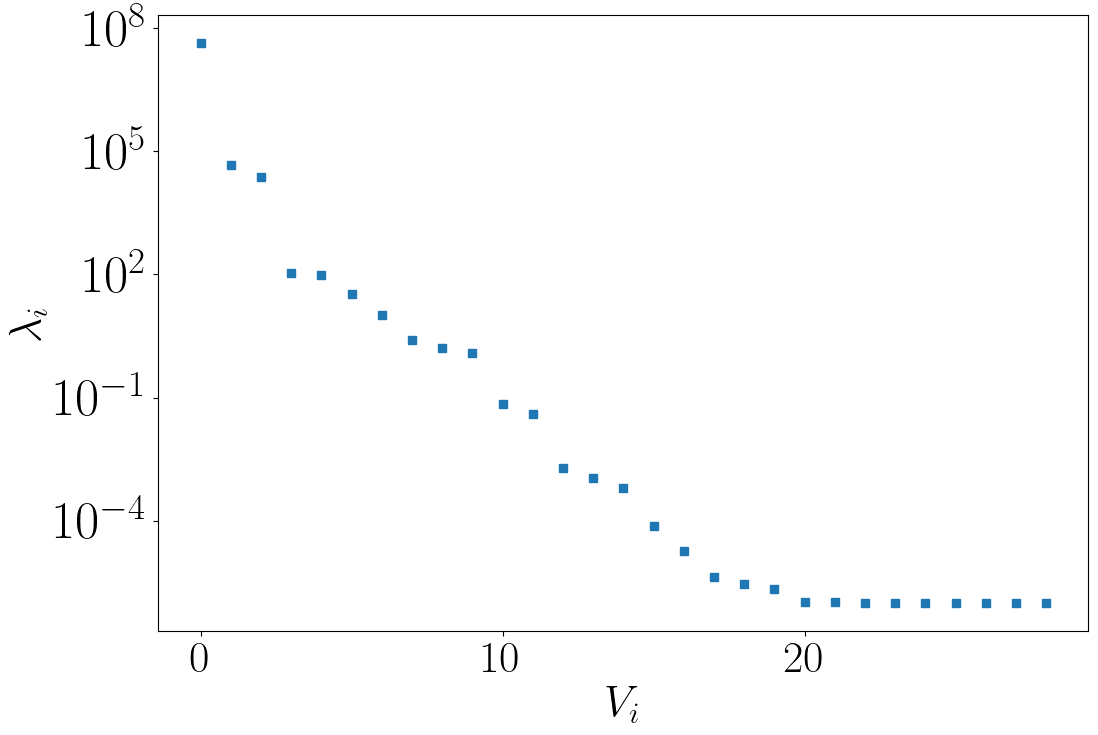

In [33]:


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(eig_val, 's', linewidth=3)
plt.yscale('log')
plt.xlabel(r'$V_i$', fontsize=32)
plt.ylabel(r'$\lambda_i$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=38)

plt.savefig("EigenVals_v2.png")


In [8]:
iter_x = np.arange(eig_vec.shape[0])[:,None]
print(iter_x.shape)


tick_labels = [r"$A$", r"$B$", r"$E$"] + \
    [r"$SF30$", r"$SF31$", r"$SF32$", r"$SF33$", r"$SF34$", r"$SF35$", r"$SF36$", r"$SF37$", r"$SF38$", r"$SF39$"] + \
    [r"$SF49$", r"$SF50$", r"$SF51$", r"$SF52$", r"$SF53$", r"$SF54$", r"$SF55$", r"$SF56$", r"$SF57$", r"$SF58$", r"$SF59$", r"$SF60$", r"$SF61$", r"$SF62$"] + \
    [r"$E_{min}$", r"$E_{\alpha}$"]


(29, 1)


In [9]:
# tick_labels = ["A", "B", "E"] + \
#     [r'SF$_30$', r'SF$_31$', r'SF$_32$', r'SF$_33$', r'SF$_34$', r'SF$_35$', r'SF$_36$', r'SF$_37$', r'SF$_38$', r'SF$_39$'] + \
#     [r'SF$_49$', r'SF$_50$', r'SF$_51$', r'SF$_52$', r'SF$_53$', r'SF$_54$', r'SF$_55$', r'SF$_56$', r'SF$_57$', r'SF$_58$', r'SF$_59$', r'SF$_60$', r'SF$_61$', r'SF$_62$' ] + \
#     [r'E_\min', r'E_\alpha']

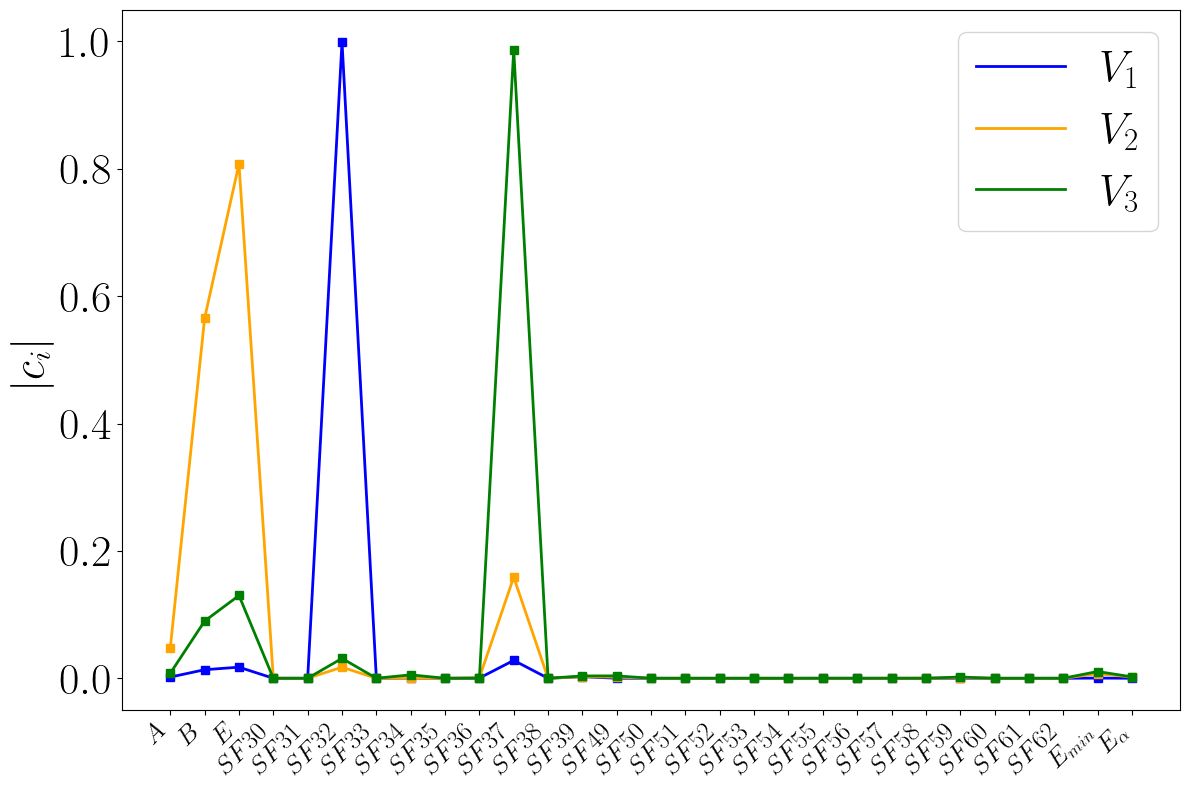

In [10]:



fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(iter_x, np.abs(eig_vec[:,0]), 's', linewidth=3, color="blue")
ax.plot(iter_x, np.abs(eig_vec[:,0]), linewidth=2, color="blue", label=r"$V_1$")

ax.plot(iter_x, np.abs(eig_vec[:,1]), 's', linewidth=3, color="orange")
ax.plot(iter_x, np.abs(eig_vec[:,1]), linewidth=2, color="orange", label=r"$V_2$")

ax.plot(iter_x, np.abs(eig_vec[:,2]), 's', linewidth=3, color="green")
ax.plot(iter_x, np.abs(eig_vec[:,2]), linewidth=2, color="green", label=r"$V_3$")


plt.xticks(ticks=iter_x.squeeze(), labels=tick_labels, rotation=45, ha='right')
plt.ylabel(r'$|c_i|$', fontsize=32)
ax.tick_params(axis='x', labelsize=19)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=32)

plt.tight_layout() 

# plt.savefig("EigenVec_set.png")

In [11]:
print(iter_x)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]]


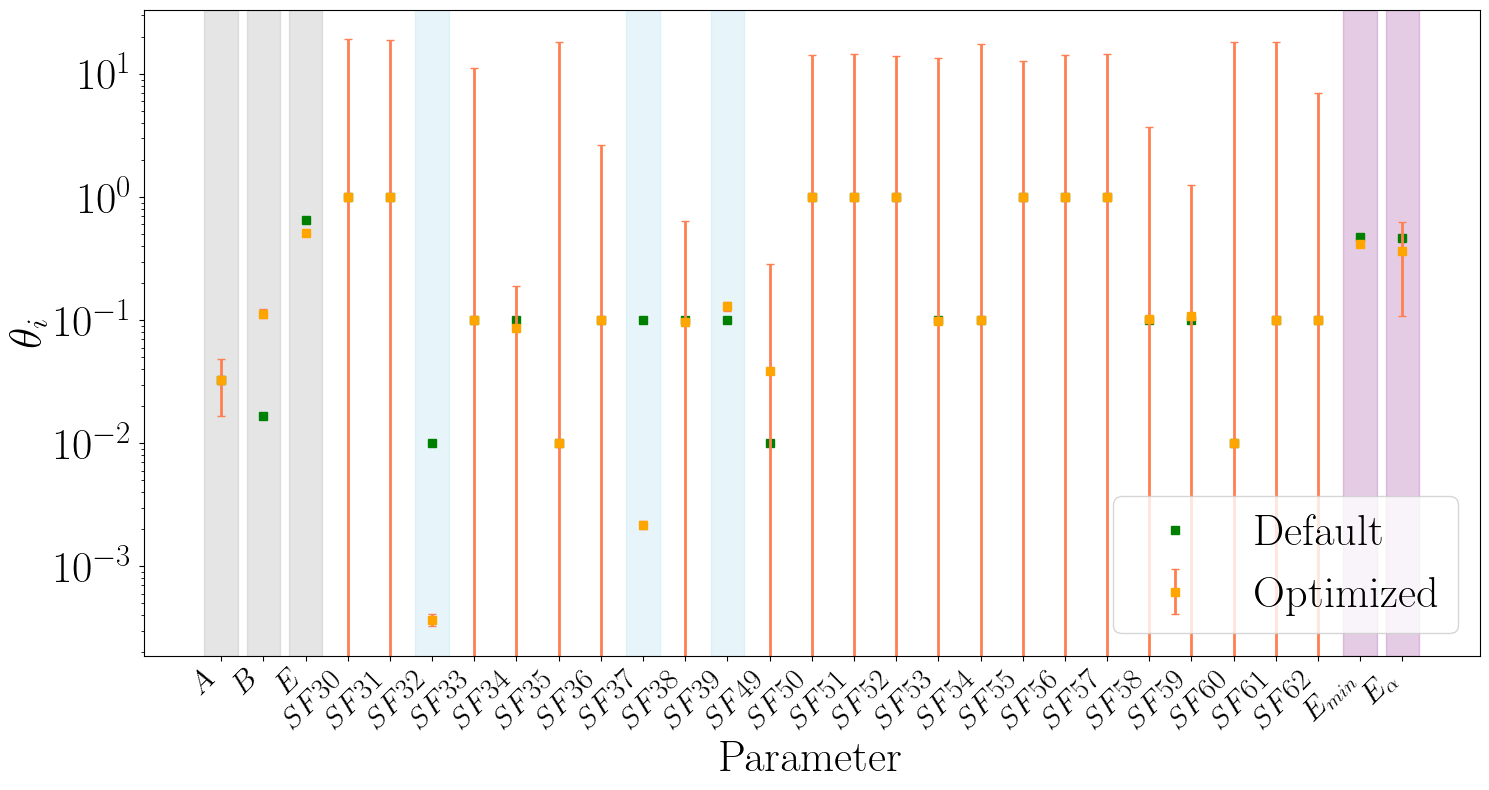

In [27]:
# plt.plot(iter_x, best_params, "x")

color_exp = "blue"
color_paper = "green"
color_opt = "orange"

params_default_paper_norm = (params_default_paper - lower_bounds) * np.reciprocal(upper_bounds - lower_bounds)

fig, ax = plt.subplots(figsize=(15, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.plot(iter_x, params_default_paper_norm, "s", linewidth=3, label="Default", color=color_paper)
plt.errorbar(iter_x, best_params, yerr=delta_theta_norm/2, fmt='s',
             ecolor='coral', elinewidth=2, capsize=3,
             label='Optimized', color=color_opt)


colors=["grey", "skyblue", "purple"]

### 1
bar_center_x = [0.0, 1.0, 2.0] 
bar_width = 0.8     
for i in range(len(bar_center_x)):
    xmin = bar_center_x[i] - bar_width / 2
    xmax = bar_center_x[i] + bar_width / 2
    ax.axvspan(
        xmin,
        xmax,
        color=colors[0],      
        alpha=0.2,       
    )

### 2
bar_center_x = [5.0, 10.0, 12.0] 
bar_width = 0.8     
for i in range(len(bar_center_x)):
    xmin = bar_center_x[i] - bar_width / 2
    xmax = bar_center_x[i] + bar_width / 2
    ax.axvspan(
        xmin,
        xmax,
        color=colors[1],      
        alpha=0.2,       
    )


### 2
bar_center_x = [27.0, 28.0] 
bar_width = 0.8     
for i in range(len(bar_center_x)):
    xmin = bar_center_x[i] - bar_width / 2
    xmax = bar_center_x[i] + bar_width / 2
    ax.axvspan(
        xmin,
        xmax,
        color=colors[2],      
        alpha=0.2,       
    )




plt.yscale('log')
plt.xlabel(r'Parameter', fontsize=32)
plt.xlabel(r'$\theta_i$', fontsize=32)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=32)
plt.legend(fontsize=32)

plt.xticks(ticks=iter_x.squeeze(), labels=tick_labels, rotation=45, ha='right')
plt.tight_layout() 

plt.savefig("Params_comparison_2.png")


In [17]:

pressures_vec = np.array([ele['pressure'] for ele in sim.exp_data_arr])
Tnw_vec = np.array([ele['Tnw'] for ele in sim.exp_data_arr])
CO_den = np.array([ele['CO'] for ele in sim.exp_data_arr])


In [18]:

params_default_paper_norm = (params_default_paper - lower_bounds) * np.reciprocal(upper_bounds - lower_bounds)
loss_val_paper, _, _, _, gammas_predicted_arr_paper = optimizer.objective_function_diff(params_default_paper_norm)

In [ ]:
# plt.figure()
# plt.plot(300.0 * np.reciprocal(Tnw_vec), optimizer.gamma_exp_data, '.')
# plt.plot(300.0 * np.reciprocal(Tnw_vec), gammas_predicted_arr, 'x')
# plt.plot(300.0 * np.reciprocal(Tnw_vec), gammas_predicted_arr_paper, 'x')

In [19]:
mask_low_CO = np.logical_and(pressures_vec < 1.1, CO_den > 0.0)
mask_high_CO = np.logical_and(pressures_vec >= 1.1, CO_den > 0.0)

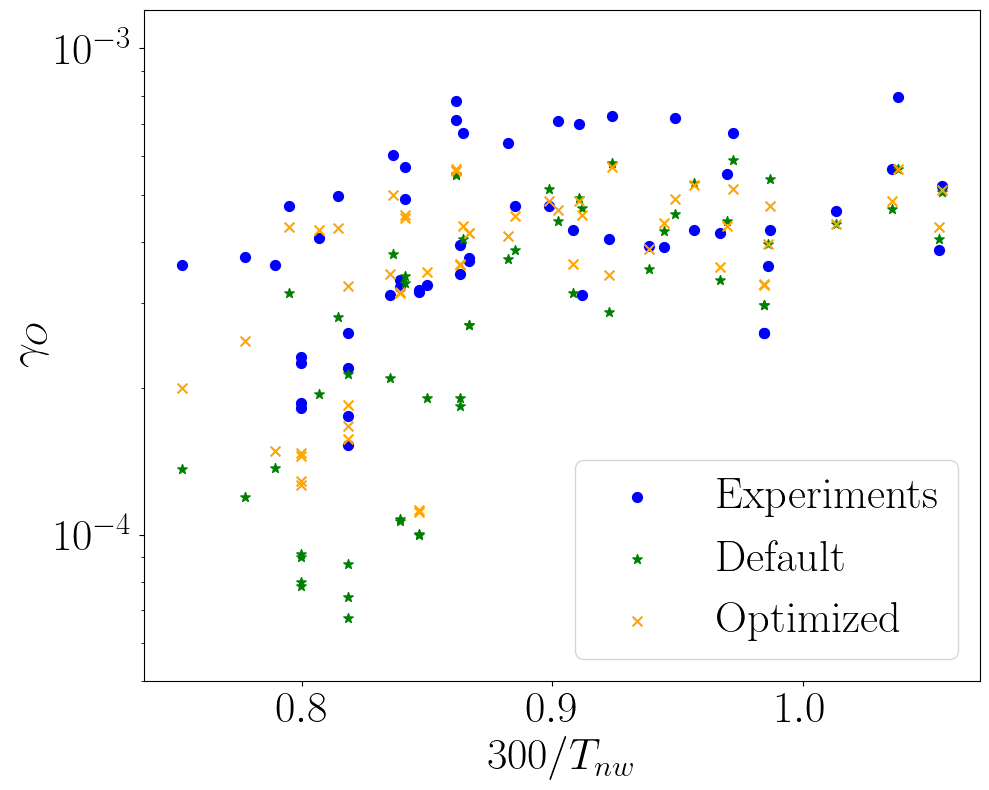

In [30]:

fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# plt.title(r"CO + O data, P $<$ 1 Torr", fontsize=30)
plt.xlabel(r'$300/T_{nw}$', fontsize=32)
plt.ylabel(r'$\gamma_O$', fontsize=32)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)

ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_low_CO], optimizer.gamma_exp_data[mask_low_CO], marker="o", s=50, label="Experiments", color=color_exp)
ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_low_CO], gammas_predicted_arr_paper[mask_low_CO], marker="*", s=50, label="Default", color=color_paper)
ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_low_CO], gammas_predicted_arr[mask_low_CO], marker="x", s=50, label="Optimized", color=color_opt)

plt.yscale('log')
plt.tight_layout()
plt.legend(fontsize=32)
plt.ylim(5e-5, 1.2e-3)
plt.savefig("results_CO_O_low_paper.png")


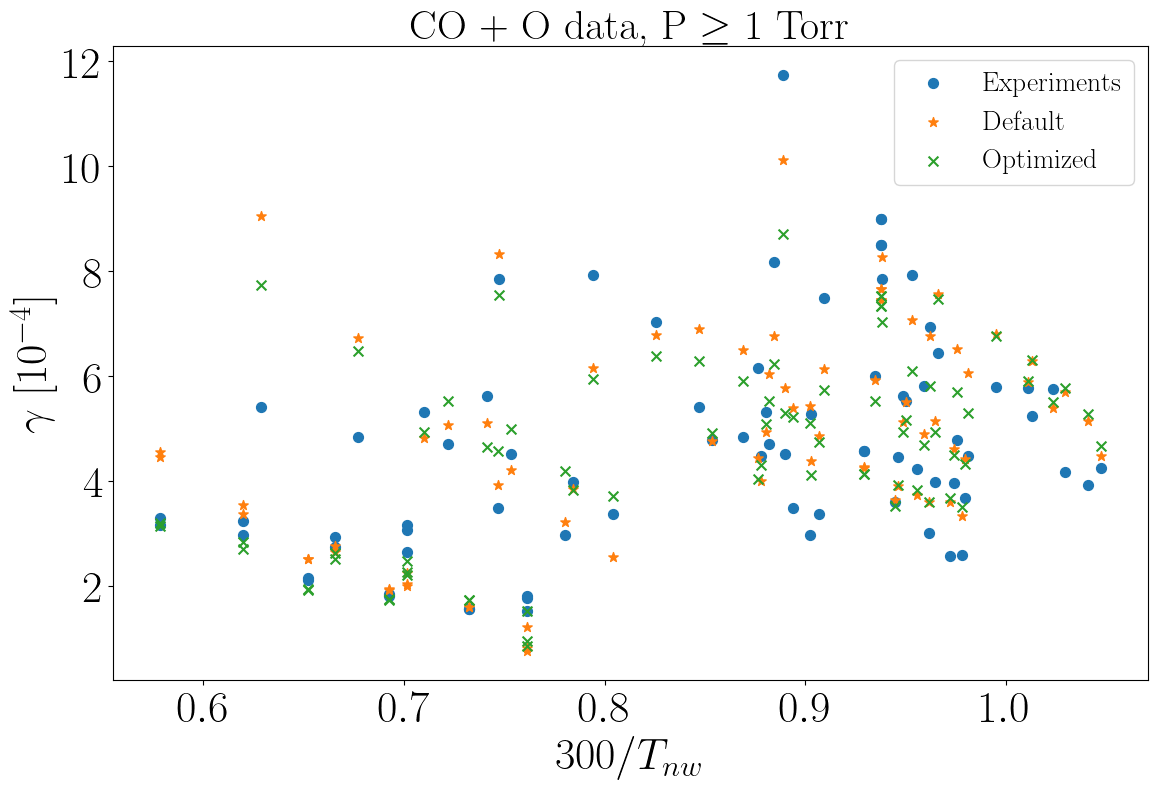

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

# plt.title(r"CO + O data, P $\geq$ 1 Torr", fontsize=30)
# plt.xlabel(r'$300/T_{nw}$', fontsize=32)
# plt.ylabel(r'$\gamma$ $[10^{-4}]$', fontsize=32)
# ax.tick_params(axis='x', labelsize=32)
# ax.tick_params(axis='y', labelsize=32)

# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_high_CO], 1e4*optimizer.gamma_exp_data[mask_high_CO], marker="o", s=50, label="Experiments")
# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_high_CO], 1e4*gammas_predicted_arr_paper[mask_high_CO], marker="*", s=50, label="Default")
# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_high_CO], 1e4*gammas_predicted_arr[mask_high_CO], marker="x", s=50, label="Optimized")

# plt.tight_layout()
# plt.legend(fontsize=20)
# # plt.savefig("results_CO_O_high.png")



In [ ]:
# mask_low_O = np.logical_and(pressures_vec < 1.1, CO_den == 0.0)
# mask_high_O = np.logical_and(pressures_vec >= 1.1, CO_den == 0.0)

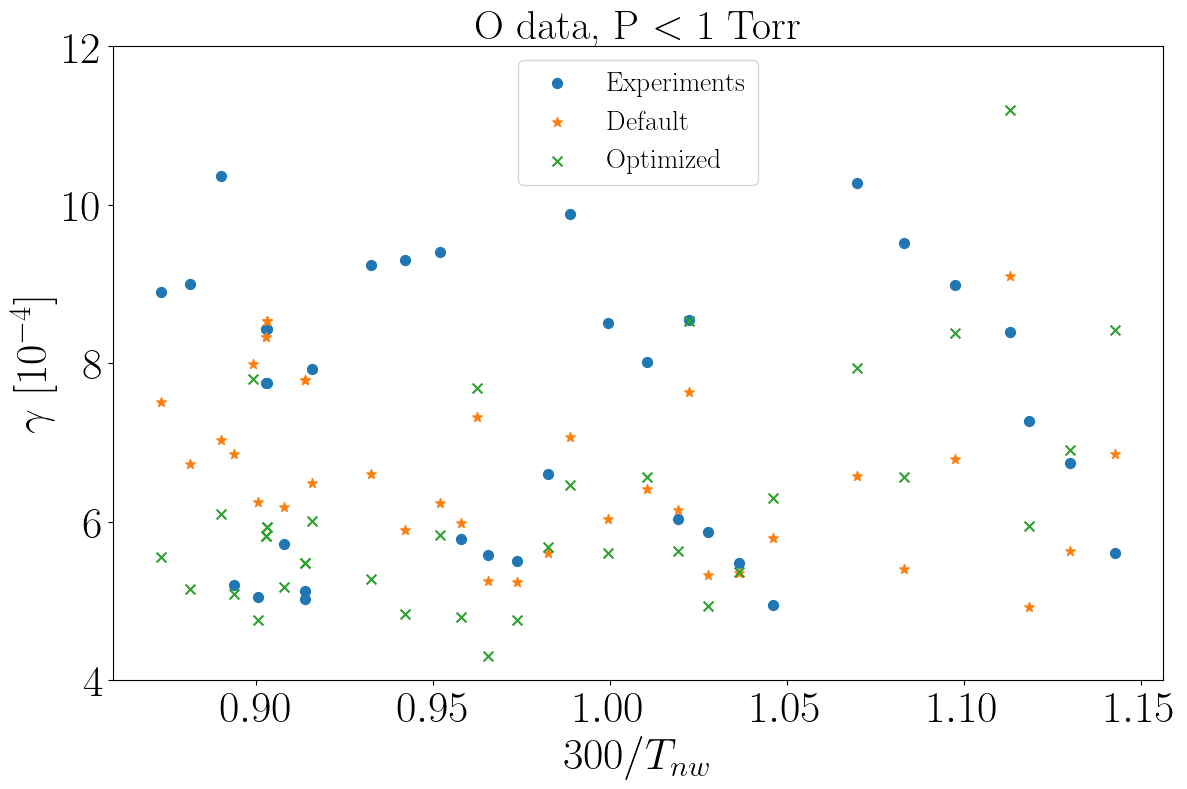

In [ ]:

# fig, ax = plt.subplots(figsize=(12, 8))
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

# plt.title(r"O data, P $<$ 1 Torr", fontsize=30)
# plt.xlabel(r'$300/T_{nw}$', fontsize=32)
# plt.ylabel(r'$\gamma$ $[10^{-4}]$', fontsize=32)
# ax.tick_params(axis='x', labelsize=32)
# ax.tick_params(axis='y', labelsize=32)

# plt.ylim(0.0004*1e4, 0.0012*1e4)


# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_low_O], 1e4*optimizer.gamma_exp_data[mask_low_O], marker="o", s=50, label="Experiments")
# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_low_O], 1e4*gammas_predicted_arr_paper[mask_low_O], marker="*", s=50, label="Default")
# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_low_O], 1e4*gammas_predicted_arr[mask_low_O], marker="x", s=50, label="Optimized")

# plt.tight_layout()
# plt.legend(fontsize=20)
# # plt.savefig("results_O_low.png")

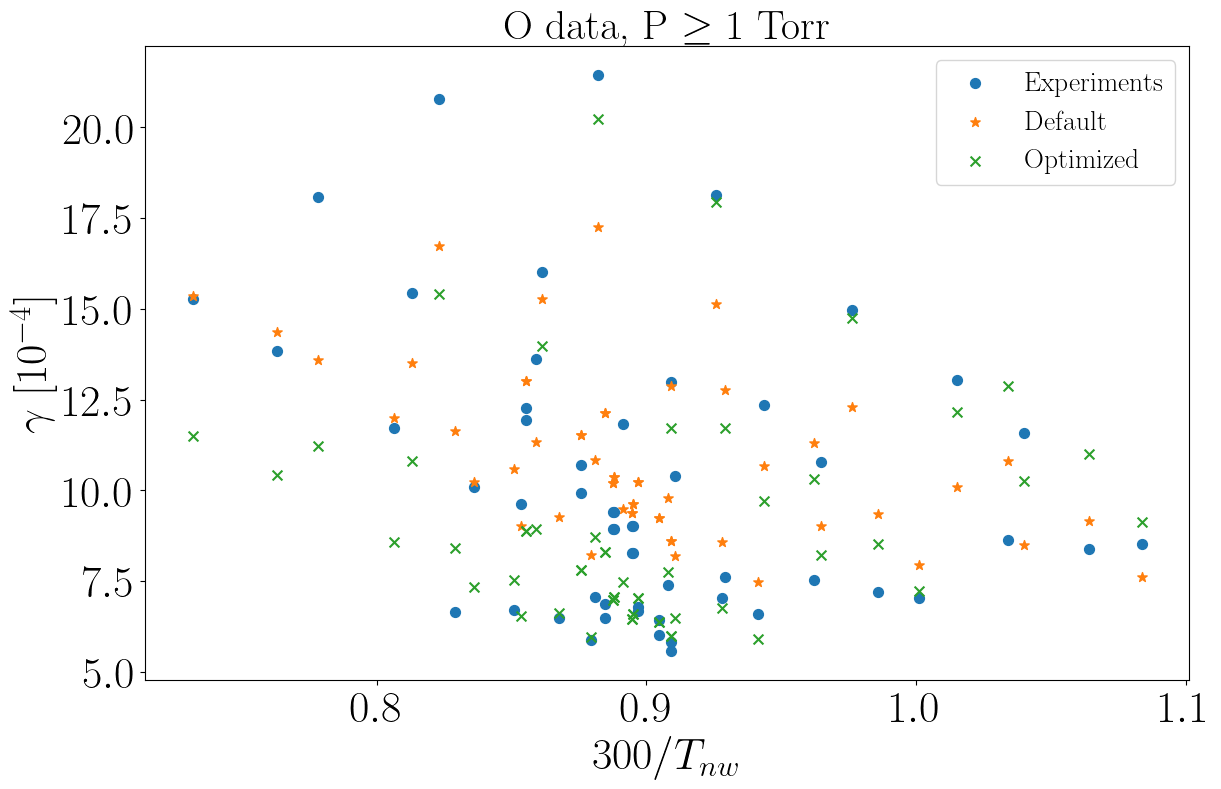

In [ ]:

# fig, ax = plt.subplots(figsize=(12, 8))
# plt.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

# plt.title(r"O data, P $\geq$ 1 Torr", fontsize=30)
# plt.xlabel(r'$300/T_{nw}$', fontsize=32)
# plt.ylabel(r'$\gamma$ $[10^{-4}]$', fontsize=32)
# ax.tick_params(axis='x', labelsize=32)
# ax.tick_params(axis='y', labelsize=32)


# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_high_O], 1e4*optimizer.gamma_exp_data[mask_high_O], marker="o", s=50, label="Experiments")
# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_high_O], 1e4*gammas_predicted_arr_paper[mask_high_O], marker="*", s=50, label="Default")
# ax.scatter(300.0 * np.reciprocal(Tnw_vec)[mask_high_O], 1e4*gammas_predicted_arr[mask_high_O], marker="x", s=50, label="Optimized")

# plt.tight_layout()
# plt.legend(fontsize=20)
# # plt.savefig("results_O_high.png")